In [1]:
import pandas as pd
import networkx as nx
#import scipy
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import powerlaw
import mpmath

### Load Data

" Only transactions between two EoA addresses have been considered in this work. We did so because the main objective of this work is to discover and analyze the behavior of communities participating in the buying and selling of NFTs. Thus, we attempted to eliminate at least some of the biases by discarding all the transactions made by smart contracts and not by generic wallets (the latter likely corresponding to actual users). In addition, we eliminated the mint node: every transaction between the mint node and a generic node of the graph was saved as a parameter of the node itself. This additional parameter, discussed in the next sections, allows to calculate the distribution of node in-degrees and the flows of tokens within the network without disrupting connectivity and clustering analysis"

In [2]:
nft_list = ["Acclimated_Moon_Cats","Art_Blocks","Bored_Ape_Yacht_Club","Cryptopunks",
           "CryptoVoxels","Decentraland","HashMasks","Meebits"]
nft_df = {}
combine = pd.DataFrame()
for i in nft_list:
    path = "cleanData2/"+i+"2.csv"
    df = pd.read_csv(path)
    df = df[(df.Wallets == 'EoAs')&(df.Transactions != 'Mint')]
    nft_df[i] = df

    combine = pd.concat([combine,df])

nft_df["combine"] = combine

In [3]:
combine.shape

(125530, 12)

### Graph

In [4]:
def make_graphs(df):
    #undirected graph
    G = nx.from_pandas_edgelist(df, source=' from_address', 
                                target=' to_address', edge_attr=['value'],)
    #largest connected subgraph
    LG = [G.subgraph(c).copy() for c in sorted(nx.connected_components(G),key = len,reverse = True)][0]
    #directed graph
    DG = nx.from_pandas_edgelist(df, source=' from_address', 
                                  target=' to_address', edge_attr=['value'],
                                 create_using = nx.DiGraph(),)    
    #multi-directed graph
    MG = nx.from_pandas_edgelist(df, source=' from_address', 
                                  target=' to_address', edge_attr=['value'],
                                 create_using = nx.MultiDiGraph(),)  
    return G,LG,DG,MG

In [5]:
nft_df.keys()

dict_keys(['Acclimated_Moon_Cats', 'Art_Blocks', 'Bored_Ape_Yacht_Club', 'Cryptopunks', 'CryptoVoxels', 'Decentraland', 'HashMasks', 'Meebits', 'combine'])

### Number of Nodes(Vertices) and Edges

In [6]:
Graph_dict = {}

for nft in nft_df.keys():
    G,LG,DG,MG = make_graphs(nft_df[nft])
    Graph_dict[nft]={}
    Graph_dict[nft]["G"]=G
    Graph_dict[nft]["LG"]=LG
    Graph_dict[nft]["DG"]=DG
    Graph_dict[nft]["MG"]=MG

    print(nft,"G: ",Graph_dict[nft]["G"])
    print(nft,"LG: ",Graph_dict[nft]["LG"])
    print(nft,"DG: ",Graph_dict[nft]["DG"])
    print(nft,"MG: ",Graph_dict[nft]["MG"])

#print(Graph_dict)

Acclimated_Moon_Cats G:  Graph with 1023 nodes and 1507 edges
Acclimated_Moon_Cats LG:  Graph with 823 nodes and 1398 edges
Acclimated_Moon_Cats DG:  DiGraph with 1023 nodes and 1525 edges
Acclimated_Moon_Cats MG:  MultiDiGraph with 1023 nodes and 2316 edges
Art_Blocks G:  Graph with 7096 nodes and 20803 edges
Art_Blocks LG:  Graph with 6660 nodes and 20534 edges
Art_Blocks DG:  DiGraph with 7096 nodes and 21195 edges
Art_Blocks MG:  MultiDiGraph with 7096 nodes and 27745 edges
Bored_Ape_Yacht_Club G:  Graph with 7093 nodes and 16757 edges
Bored_Ape_Yacht_Club LG:  Graph with 6969 nodes and 16680 edges
Bored_Ape_Yacht_Club DG:  DiGraph with 7093 nodes and 17103 edges
Bored_Ape_Yacht_Club MG:  MultiDiGraph with 7093 nodes and 19907 edges
Cryptopunks G:  Graph with 4189 nodes and 11503 edges
Cryptopunks LG:  Graph with 4140 nodes and 11473 edges
Cryptopunks DG:  DiGraph with 4189 nodes and 11798 edges
Cryptopunks MG:  MultiDiGraph with 4189 nodes and 23119 edges
CryptoVoxels G:  Graph wi

### Path lengths, radius and diameter

#### Mean Distance (Average Path Length):

The average of the shortest path lengths for all possible node pairs. Gives a measure of ‘tightness’ of the Graph and can be used to understand how quickly/easily something flows in this Network.

#### Radius: 
The radius is the minimum eccentricity.

#### Diameter: 
The diameter is the maximum eccentricity.

In [7]:
def graph_stat(G):
    avg_path_len = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
    radius = nx.radius(G)
    return avg_path_len, diameter, radius

In [8]:
graph_stat_df = pd.DataFrame(index=Graph_dict.keys(), columns = ["Nodes", "Edges","Avg Path Length","Diameter","Radius"])

#Takes 20 minutes to run
for nft in Graph_dict.keys():
    g = Graph_dict[nft]["LG"]
    graph_stat_df.loc[nft,"Nodes"] = g.number_of_nodes()
    graph_stat_df.loc[nft,"Edges"] = g.number_of_edges()
    graph_stat_df.loc[nft,"Avg Path Length"], graph_stat_df.loc[nft,"Diameter"], graph_stat_df.loc[nft,"Radius"] = graph_stat(g)
    
    print(nft)
print(graph_stat_df)

Acclimated_Moon_Cats
Art_Blocks
Bored_Ape_Yacht_Club
Cryptopunks
CryptoVoxels
Decentraland
HashMasks
Meebits
combine
                      Nodes  Edges Avg Path Length Diameter Radius
Acclimated_Moon_Cats    823   1398        4.345159       12      6
Art_Blocks             6660  20534        4.030347       12      6
Bored_Ape_Yacht_Club   6969  16680        4.175903       12      7
Cryptopunks            4140  11473        3.941055       12      6
CryptoVoxels           2067   4244        3.238431        9      5
Decentraland           4288   8275        4.103887       13      7
HashMasks              5899  12453        4.210478       26     13
Meebits                3673   6395        4.884707       13      7
combine               27271  80882        4.460887       29     15


In [159]:
for i in range(0,9):
    print("\hline",graph_stat_df.index[i],"&",round(graph_stat_df.iloc[i,2],3),"&",round(graph_stat_df.iloc[i,3],3),"&",
          round(graph_stat_df.iloc[i,4],3),"\\\\")

\hline Acclimated_Moon_Cats & 4.345 & 12 & 6 \\
\hline Art_Blocks & 4.03 & 12 & 6 \\
\hline Bored_Ape_Yacht_Club & 4.176 & 12 & 7 \\
\hline Cryptopunks & 3.941 & 12 & 6 \\
\hline CryptoVoxels & 3.238 & 9 & 5 \\
\hline Decentraland & 4.104 & 13 & 7 \\
\hline HashMasks & 4.21 & 26 & 13 \\
\hline Meebits & 4.885 & 13 & 7 \\
\hline combine & 4.461 & 29 & 15 \\


### Network Graph Power Law

alpha value

p-value

test statistics of the Kolmogorov-smirnov test

"test whether the degree distribution follows a power law. For this, we first need the degree distribution. This is again given as a dictionary, but it does not matter which node has what degree. Since we cannot access the values from the DegreeView directly, we first convert it to a dictionary, extract the values and convert the values to a list.

Now we have the list of degrees, we can use the powerlaw package to extract the parameters of the power law distribution fit to the data and then test whether a power law distribution or another distribution better fits the data. If the likelihood (first value) is positive, then the first distribution is more likely. If it is negative, the second distribution fits the data better. The p-value (second value) tests whether the sign of the likelihood is significant. Which distribution do you think has the best fit?"


fitted a parameter alpha and its standard error sigma

In [148]:
power_stat_df = pd.DataFrame(index=Graph_dict.keys(), 
                             columns = ["In_alpha", "In_sigma","In_KS","In_p",
                                        "Out_alpha", "Out_sigma",
                                        "Out_KS","Out_p"])
power_in_fit = {}
power_out_fit = {}

for nft in Graph_dict.keys():
    G = Graph_dict[nft]["MG"]
    in_deg = dict(G.in_degree())
    in_deg = list(in_deg.values())
    in_deg = [i for i in in_deg if i >0]
    in_fit = powerlaw.Fit(in_deg, discrete=True)
    
    power_stat_df.loc[nft,"In_alpha"] = in_fit.alpha
    power_stat_df.loc[nft,"In_sigma"] = in_fit.sigma
    power_stat_df.loc[nft,"In_KS"] = in_fit.D
    #KS distance
    
    #KS p-value
    
    #print(nft,in_fit.distribution_compare('power_law', 'exponential'))
    
    out_deg = dict(G.out_degree())
    out_deg = list(out_deg.values())
    out_deg = [i for i in out_deg if i >0]
    out_fit = powerlaw.Fit(out_deg, discrete=True)
    power_stat_df.loc[nft,"Out_alpha"] = out_fit.alpha
    power_stat_df.loc[nft,"Out_sigma"] = out_fit.sigma
    power_stat_df.loc[nft,"Out_KS"] = round(in_fit.D,3)
    #print(nft,out_fit.distribution_compare('power_law', 'exponential'))
    
    power_in_fit[nft] = in_fit
    power_out_fit[nft] = out_fit

print(power_stat_df)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
                      In_alpha  In_sigma     In_KS In_p Out_alpha Out_sigma  \
Acclimated_Moon_Cats  2.012097  0.059742  0.024646  NaN  2.209943  0.115364   
Art_Blocks            1.997237   0.03227  0.045106  NaN  1.988553  0.021521   
Bored_Ape_Yacht_Club  2.360194  0.038228  0.024465  NaN   2.09637  0.033722   
Cryptopunks           1.840181  0.019285  0.017742  NaN  1.728277  0.020876   
CryptoVoxels          1.858118  0.027136  0.028663  NaN   1.86254  0.036416   
Decentraland          2.034764  0.032657  0.013327  NaN  1.964699  0.034653   
HashMasks             1.989098  0.022228  0.016244  NaN  2.046118  0.037314   
Meebits               2.119018  0.032617  0.022911  NaN  2.023959  0.031691   
combine                1.84679  0.007869  0.

In [116]:
for i in range(0,9):
    print(round(power_stat_df.iloc[i,0],3),"&",round(power_stat_df.iloc[i,2],3),"&",
          round(power_stat_df.iloc[i,4],3),"&",round(power_stat_df.iloc[i,6],3))

2.313 & 0.033 & 2.014 & 0.033
1.655 & 0.046 & 1.904 & 0.046
2.488 & 0.023 & 2.139 & 0.023
2.045 & 0.028 & 1.825 & 0.028
2.253 & 0.029 & 1.986 & 0.029
2.318 & 0.019 & 2.058 & 0.019
2.216 & 0.018 & 2.095 & 0.018
2.353 & 0.028 & 2.07 & 0.028
1.967 & 0.023 & 1.862 & 0.023


Probability density function (p(X), blue) and complemenatary cumulative distribution function (p(X>=x), red) of Indegree.

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Text(0.5, 0, 'Out-degree')

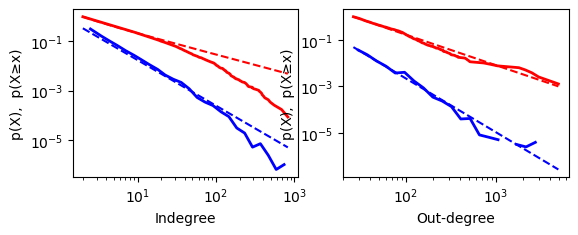

In [17]:
#data = power_in_fit
fit = powerlaw.Fit(data, discrete=True)
####
plt.subplot(2, 2, 1)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)

fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)

####
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"Indegree")

plt.subplot(2, 2, 2)
data = out_deg
fit = powerlaw.Fit(data, discrete=True)
####
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)

fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)

####
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"Out-degree")

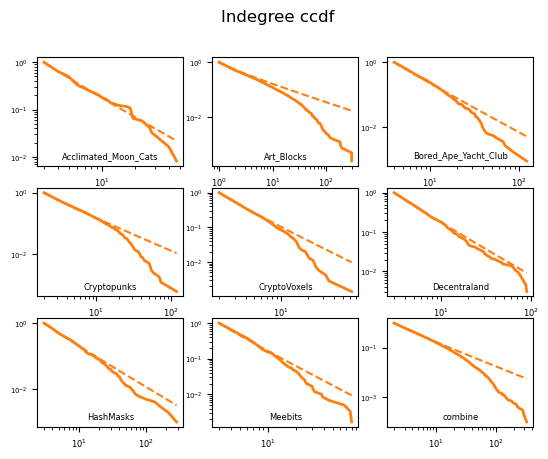

In [118]:
color = list(mcolors.TABLEAU_COLORS.values())

        
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    nft = list(power_in_fit.keys())[i]
    fit = power_in_fit[nft]
  
    #figCCDF = fit.plot_pdf(color='#1f77b4', linewidth=2,label=r"Empirical PDF")
    #fit.power_law.plot_pdf(color='#1f77b4', linestyle='--', ax=figCCDF,label=r"PDF")

    figCCDF =fit.plot_ccdf(color='#ff7f0e', linewidth=2)#ax=figCCDF,label=r"Empirical CCDF")
    fit.power_law.plot_ccdf(color='#ff7f0e', linestyle='--', ax=figCCDF,label=r"CCDF")
    
    plt.title(nft, fontsize=6,y=-0.01)

    plt.suptitle("Indegree ccdf")

    plt.xticks(fontsize=6)
    plt.yticks(fontsize=5)



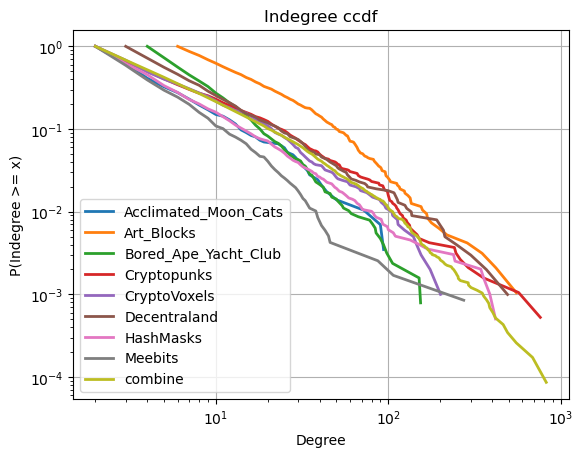

In [153]:
color = list(mcolors.TABLEAU_COLORS.values())
             


#plt.figure(figsize=(8,5))
for i in range(0,9):
    nft = list(power_in_fit.keys())[i]
    fit = power_in_fit[nft]
  
    #figCCDF = fit.plot_pdf(color='#1f77b4', linewidth=2,label=r"Empirical PDF")
    #fit.power_law.plot_pdf(color='#1f77b4', linestyle='--', ax=figCCDF,label=r"PDF")

    figCCDF =fit.plot_ccdf(color=color[i], linewidth=2)#ax=figCCDF,label=r"Empirical CCDF")
    #fit.power_law.plot_ccdf(color=color[i], linestyle='--', ax=figCCDF,label=r"CCDF")
    
    #plt.title(nft, fontsize=6,y=-0.01)

    plt.title("Indegree ccdf")

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
plt.legend(power_in_fit.keys())
plt.xlabel("Degree")
plt.ylabel("P(Indegree >= x)")
plt.grid()
plt.savefig("Indegree CCDF.png")

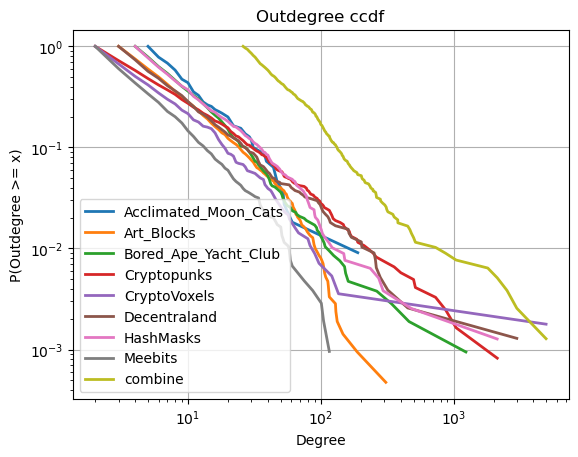

In [154]:
             
#plt.figure(figsize=(8,5))
for i in range(0,9):
    nft = list(power_out_fit.keys())[i]
    fit = power_out_fit[nft]
  
    #figCCDF = fit.plot_pdf(color='#1f77b4', linewidth=2,label=r"Empirical PDF")
    #fit.power_law.plot_pdf(color='#1f77b4', linestyle='--', ax=figCCDF,label=r"PDF")

    figCCDF =fit.plot_ccdf(color=color[i], linewidth=2)#ax=figCCDF,label=r"Empirical CCDF")
    #fit.power_law.plot_ccdf(color=color[i], linestyle='--', ax=figCCDF,label=r"CCDF")
    
    #plt.title(nft, fontsize=6,y=-0.01)

    plt.title("Outdegree ccdf")

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
plt.legend(power_in_fit.keys())
plt.xlabel("Degree")
plt.ylabel("P(Outdegree >= x)")
plt.grid()


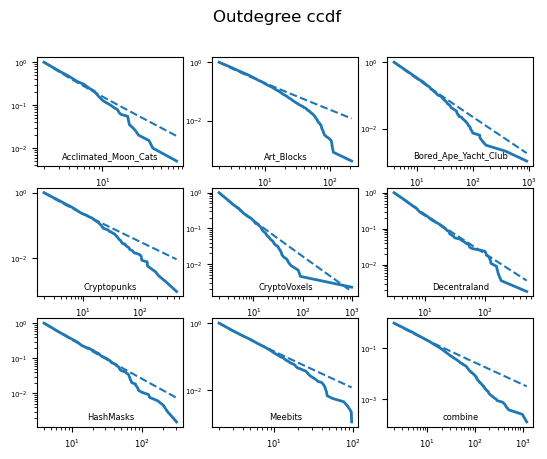

In [121]:
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    nft = list(power_out_fit.keys())[i]
    fit = power_out_fit[nft]
  
    #figCCDF = fit.plot_pdf(color='#1f77b4', linewidth=2,label=r"Empirical PDF")
    #fit.power_law.plot_pdf(color='#1f77b4', linestyle='--', ax=figCCDF,label=r"PDF")

    figCCDF =fit.plot_ccdf(color=≈, linewidth=2)#ax=figCCDF,label=r"Empirical CCDF")
    fit.power_law.plot_ccdf(color='#1f77b4', linestyle='--', ax=figCCDF,label=r"CCDF")
    
    plt.title(nft, fontsize=6,y=-0.01)

    plt.suptitle("Outdegree ccdf")

    plt.xticks(fontsize=6)
    plt.yticks(fontsize=5)

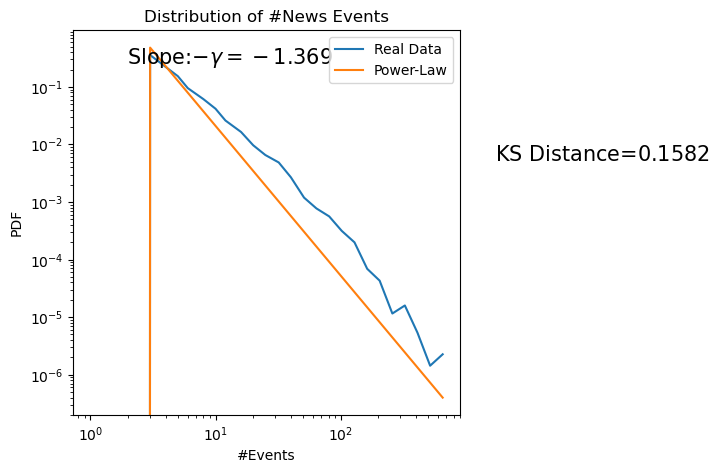

In [91]:
f, ax = plt.subplots(figsize=(5, 5))
ax.set(xscale="log", yscale="log")
line1, = ax.plot(x[:-1], df["pdf4fit"], label="Real Data")
line2, = ax.plot(x[:-1], df["f2"], label="Power-Law")

#ax.text(20, 4500, r'Goodness of fit', color='red', fontsize=15)
#ax.text(50, 2000, r'$R^2=0.873$', color='red', fontsize=15)

ax.set_title('Distribution of #News Events')

ax.set_xlabel('#Events')
ax.set_ylabel('PDF')
ax.text(13, 0.2, r'Slope:$-\gamma=-1.369$', fontsize=15,\
        horizontalalignment='center', verticalalignment='bottom')

ax.text(88530, 0.01, r'KS Distance=$0.1582$', fontsize=15,\
        horizontalalignment='right', verticalalignment='top')

plt.legend()
#plt.savefig("./figures/fit.png")

KS distance for synthetic sequence: 0.12792933015198027


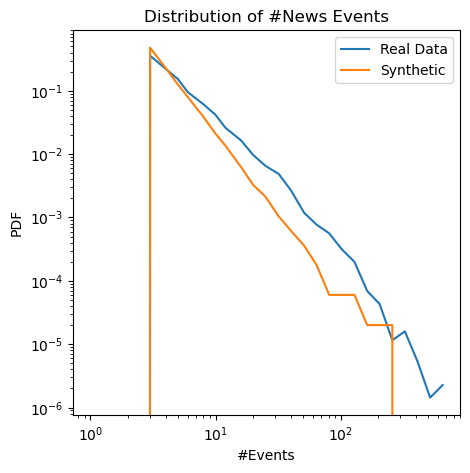

In [93]:
# the fitted distribution
def synthetic(degrees, f2):
    tmp = np.zeros(df.shape[0])
    for i in range(50000):
        deg = np.random.choice(degrees, p=f2)
        tmp[deg] += 1
    tmp = tmp / tmp.sum()
    return tmp

# the synthetic data generated by the Power-law
f3 = synthetic(df.index, df['f2'])
print ("KS distance for synthetic sequence:", ksdistance(df["pdf4fit"], f3))

# plot the synthetic data
f, ax = plt.subplots(figsize=(5, 5))
ax.set(xscale="log", yscale="log")
line1, = ax.plot(x[:-1], df["pdf4fit"], label="Real Data")
line2, = ax.plot(x[:-1], f3, label="Synthetic")
ax.set_title('Distribution of #News Events')
ax.set_xlabel('#Events')
ax.set_ylabel('PDF')
plt.legend()
#plt.savefig("./figures/synthetic.png")

In [191]:
def plot_basics(data, data_inst, fig, units):
    from powerlaw import plot_pdf, Fit, pdf
    annotate_coord = (-.4, .95)
    ax1 = fig.add_subplot(n_graphs,n_data,data_inst)
    x, y = pdf(data, linear_bins=True)
    ind = y>0
    y = y[ind]
    x = x[:-1]
    x = x[ind]
    ax1.scatter(x, y, color='r', s=.5)
    plot_pdf(data, ax=ax1, color='b', linewidth=2)
    from pylab import setp
    setp( ax1.get_xticklabels(), visible=False)

    if data_inst==1:
        ax1.annotate("A", annotate_coord, xycoords="axes fraction")

    
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    ax1in = inset_axes(ax1, width = "30%", height = "30%", loc=3)
    ax1in.hist(data, color='b')
    ax1in.set_xticks([])
    ax1in.set_yticks([])

    
    ax2 = fig.add_subplot(n_graphs,n_data,n_data+data_inst, sharex=ax1)
    plot_pdf(data, ax=ax2, color='b', linewidth=2)
    fit = Fit(data, xmin=1, discrete=True)
    fit.power_law.plot_pdf(ax=ax2, linestyle=':', color='g')
    p = fit.power_law.pdf()

    ax2.set_xlim(ax1.get_xlim())
    
    fit = Fit(data, discrete=True)
    fit.power_law.plot_pdf(ax=ax2, linestyle='--', color='g')
    from pylab import setp
    setp( ax2.get_xticklabels(), visible=False)

    if data_inst==1:
       ax2.annotate("B", annotate_coord, xycoords="axes fraction")        
       ax2.set_ylabel(u"p(X)")# (10^n)")
        
    ax3 = fig.add_subplot(n_graphs,n_data,n_data*2+data_inst)#, sharex=ax1)#, sharey=ax2)
    fit.power_law.plot_pdf(ax=ax3, linestyle='--', color='g')
    fit.exponential.plot_pdf(ax=ax3, linestyle='--', color='r')
    fit.plot_pdf(ax=ax3, color='b', linewidth=2)
    
    ax3.set_ylim(ax2.get_ylim())
    ax3.set_xlim(ax1.get_xlim())
    
    if data_inst==1:
        ax3.annotate("C", annotate_coord, xycoords="axes fraction")

    ax3.set_xlabel(units)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


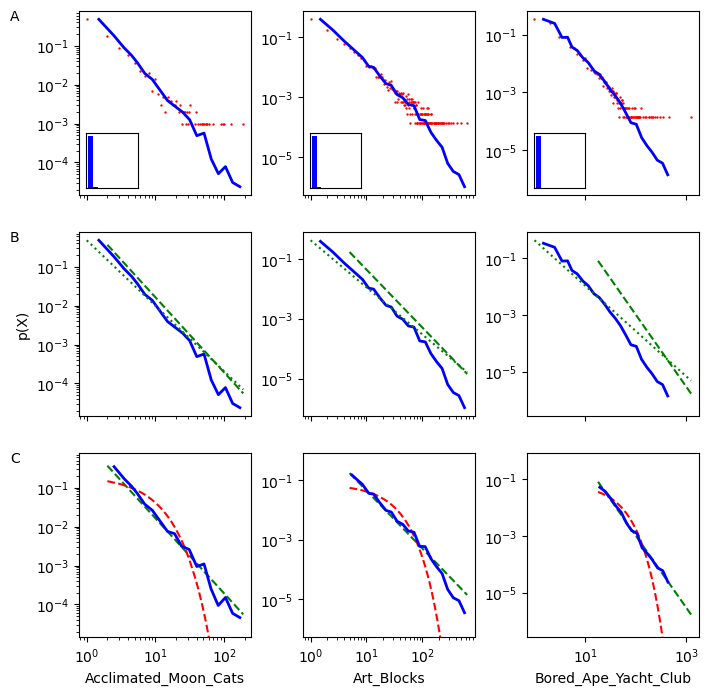

In [193]:

G = Graph_dict["Acclimated_Moon_Cats"]["MG"]
deg_a = dict(G.degree())
deg_a = list(deg_a.values())
deg_a = [i for i in deg_a if i >0]

G = Graph_dict["Art_Blocks"]["MG"]
deg_b = dict(G.degree())
deg_b = list(deg_b.values())
deg_b = [i for i in deg_b if i >0]

G = Graph_dict["Bored_Ape_Yacht_Club"]["MG"]
deg_c = dict(G.degree())
deg_c = list(deg_c.values())
deg_c = [i for i in deg_c if i >0]

n_data = 3
n_graphs = 4
f = plt.figure(figsize=(8,11))

data = deg_a
data_inst = 1
units = 'Acclimated_Moon_Cats'
plot_basics(data, data_inst, f, units)

data_inst = 2
#data = city
#units = 'City Population'
data = deg_b
units = 'Art_Blocks'
plot_basics(data, data_inst, f, units)

data = deg_c
data_inst = 3
units = 'Bored_Ape_Yacht_Club'
plot_basics(data, data_inst, f, units)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.2)
figname = 'powerlaw2'
f.savefig(figname+'.png', bbox_inches='tight',dpi=300)
#f.savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


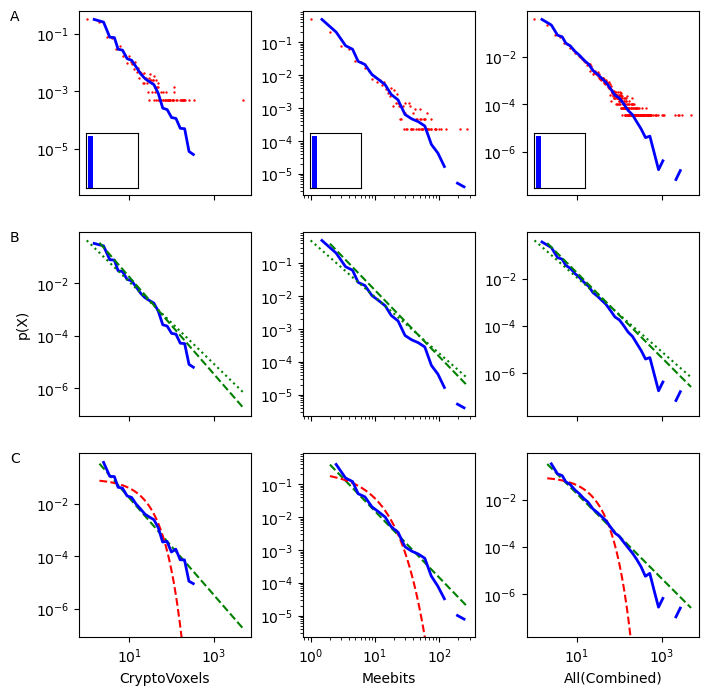

In [194]:

    
G = Graph_dict["CryptoVoxels"]["MG"]
deg_a = dict(G.degree())
deg_a = list(deg_a.values())
deg_a = [i for i in deg_a if i >0]

G = Graph_dict["Meebits"]["MG"]
deg_b = dict(G.degree())
deg_b = list(deg_b.values())
deg_b = [i for i in deg_b if i >0]

G = Graph_dict["combine"]["MG"]
deg_c = dict(G.degree())
deg_c = list(deg_c.values())
deg_c = [i for i in deg_c if i >0]

n_data = 3
n_graphs = 4
f = plt.figure(figsize=(8,11))

data = deg_a
data_inst = 1
units = 'CryptoVoxels'
plot_basics(data, data_inst, f, units)

data_inst = 2
#data = city
#units = 'City Population'
data = deg_b
units = 'Meebits'
plot_basics(data, data_inst, f, units)

data = deg_c
data_inst = 3
units = 'All(Combined)'
plot_basics(data, data_inst, f, units)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.2)
figname = 'powerlaw3'
f.savefig(figname+'.png', bbox_inches='tight',dpi=300)
#f.savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

In [ ]:
G = Graph_dict["Cryptopunks"]["MG"]
deg_a = dict(G.degree())
deg_a = list(deg_a.values())
deg_a = [i for i in deg_a if i >0]

G = Graph_dict["Decentraland"]["MG"]
deg_b = dict(G.degree())
deg_b = list(deg_b.values())
deg_b = [i for i in deg_b if i >0]

G = Graph_dict["HashMasks"]["MG"]
deg_c = dict(G.degree())
deg_c = list(deg_c.values())
deg_c = [i for i in deg_c if i >0]

n_data = 3
n_graphs = 4
f = plt.figure(figsize=(8,11))

data = deg_a
data_inst = 1
units = 'Cryptopunks'
plot_basics(data, data_inst, f, units)

data_inst = 2
#data = city
#units = 'City Population'
data = deg_b
units = 'Decentraland'
plot_basics(data, data_inst, f, units)

data = deg_c
data_inst = 3
units = 'HashMasks'
plot_basics(data, data_inst, f, units)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.2)
figname = 'powerlaw'
f.savefig(figname+'.png', bbox_inches='tight',dpi=300)
#f.savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

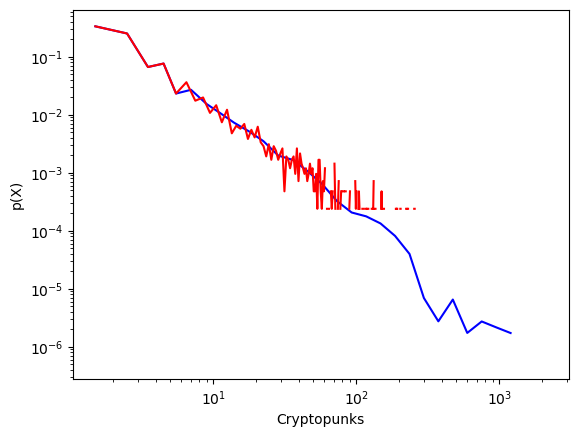

In [182]:
G = Graph_dict["Cryptopunks"]["MG"]
deg_a = dict(G.degree())
deg_a = list(deg_a.values())
deg_a = [i for i in deg_a if i >0]


data = deg_a
####
figPDF = powerlaw.plot_pdf(data, color='b')
powerlaw.plot_pdf(data, linear_bins=True, color='r', ax=figPDF)
####
figPDF.set_ylabel("p(X)")
figPDF.set_xlabel(r"Cryptopunks")
figname = 'Cryptopunksll'
plt.savefig(figname+'.png', bbox_inches='tight',dpi = 300)
#savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

In [31]:
deg = dict(mcats_G_directed.out_degree())

deg = list(deg.values())
#deg = [i for i in deg if i >0]
#print(deg[1:len(deg)])

fit = powerlaw.Fit(deg, discrete=True)
print(fit.distribution_compare('power_law', 'lognormal'))
print(fit.distribution_compare('power_law', 'exponential'))
print(fit.distribution_compare('power_law', 'lognormal_positive'))
print(fit.distribution_compare('power_law', 'stretched_exponential'))

Calculating best minimal value for power law fit
(-4.953974828251614, 0.029946490815933716)
(23.802282716163543, 0.08430516162801395)
(-4.870031114348397, 0.06765411458072346)
(-5.25604705454681, 0.026660689357894746)


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [71]:
fit.alpha
#R,p = fit.distribution_compare('power_law', 'lognormal_positive')
#print(R)
#print(p)
print('powerlaw', stats.kstest(deg, "powerlaw", args=(fit.alpha, fit.xmin), N=len(deg)))
print('lognorm', stats.kstest(deg, "lognorm", args=(np.mean(deg), np.std(deg)), N=len(deg)))

powerlaw KstestResult(statistic=0.6905236907730673, pvalue=0.0)
lognorm KstestResult(statistic=0.9516209476309226, pvalue=0.0)


### Connectivity and Clustering Statistics

#### Reciprocity

The reciprocity of a directed graph is defined as the ratio of the number of edges pointing in both directions to the total number of edges in the graph. 

The reciprocity of a single node u is defined similarly, it is the ratio of the number of edges in both directions to the total number of edges attached to node u.


#### Transitivity

Compute graph transitivity, the fraction of all possible triangles present in G.

Possible triangles are identified by the number of “triads” (two edges with a shared vertex).

"The transitivity coefficient (also known as clustering coefficient) measures the probability for adjacent nodes of a network to be connected – in other words, if there is a link e(vi, vj ) or e(vj , vi) and a link e(vj , vk ) or e(vk , vj ), what is the probability of there being a link e(vi , vk ) or e(vk , vi ). Table VI illustrates the various levels of transitivity of the graphs: they all tend towards 0, indicating that collaboration between wallets is very rare. "

#### Assortativity


In [13]:
graph_connectivity_df = pd.DataFrame(index=Graph_dict.keys(), columns = ["Assortativity", "Reciprocity", "Transitivity"])

for nft in Graph_dict.keys():
    g = Graph_dict[nft]["DG"]
    graph_connectivity_df.loc[nft,"Assortativity"] = nx.degree_assortativity_coefficient(g)
    graph_connectivity_df.loc[nft,"Reciprocity"] = nx.reciprocity(g)
    graph_connectivity_df.loc[nft,"Transitivity"]= nx.transitivity(g)
    
    print(nft)
print(graph_connectivity_df)

Acclimated_Moon_Cats
Art_Blocks
Bored_Ape_Yacht_Club
Cryptopunks
CryptoVoxels
Decentraland
HashMasks
Meebits
combine
                     Assortativity Reciprocity Transitivity
Acclimated_Moon_Cats     -0.065271    0.023607     0.014447
Art_Blocks               -0.040408     0.03699     0.027899
Bored_Ape_Yacht_Club     -0.064017    0.040461      0.00271
Cryptopunks              -0.075723    0.050008     0.015473
CryptoVoxels             -0.216734    0.076523      0.00282
Decentraland             -0.103834    0.056312     0.011919
HashMasks                -0.136926    0.047192     0.008517
Meebits                  -0.074974    0.031918     0.005015
combine                   -0.08425    0.046991     0.008186


In [14]:
graph_connectivity_df = pd.DataFrame(index=Graph_dict.keys(), columns = ["Assortativity", "Reciprocity", "Transitivity"])

for nft in Graph_dict.keys():
    g = Graph_dict[nft]["MG"]
    graph_connectivity_df.loc[nft,"Assortativity"] = nx.degree_assortativity_coefficient(g)
    graph_connectivity_df.loc[nft,"Reciprocity"] = nx.reciprocity(g)
    graph_connectivity_df.loc[nft,"Transitivity"]= nx.transitivity(Graph_dict[nft]["DG"])
    
print(graph_connectivity_df)

                     Assortativity Reciprocity Transitivity
Acclimated_Moon_Cats      0.093647     0.02418     0.014447
Art_Blocks                0.041144    0.036908     0.027899
Bored_Ape_Yacht_Club      0.001846    0.054051      0.00271
Cryptopunks               0.163124    0.039362     0.015473
CryptoVoxels              0.106759    0.051368      0.00282
Decentraland              0.206823    0.055868     0.011919
HashMasks                 0.234507    0.044048     0.008517
Meebits                   0.006323    0.038271     0.005015
combine                    0.08506     0.04802     0.008186


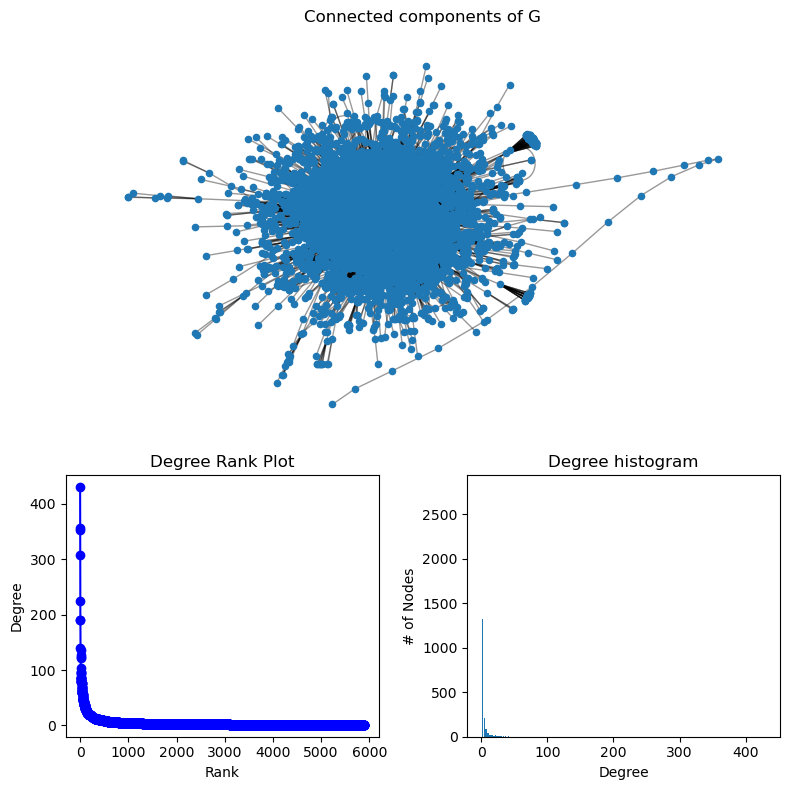

In [161]:
G = Graph_dict["HashMasks"]["LG"]

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# Pyvis Visualization

In [206]:
from pyvis.network import Network
network_graph = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
df = nft_df["HashMasks"]
sources = df[' from_address']
targets = df[' to_address']
weights = df['value']
edge_data = zip(sources, targets, weights)
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    network_graph.add_node(src, src, title=src)
    network_graph.add_node(dst, dst, title=dst)
    network_graph.add_edge(src, dst, value=w)

# add neighbor data to node hover data
neighbor_map = network_graph.get_adj_list()
for node in network_graph.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])
    
# display graph
network_graph.show('NFTMap.html')

In [208]:
from pyvis.network import Network
network_graph = Network(height='750px', width='100%', bgcolor='#CD5C5C', font_color='white')
df = nft_df["Decentraland"]
sources = df[' from_address']
targets = df[' to_address']
weights = df['value']
edge_data = zip(sources, targets, weights)
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    network_graph.add_node(src, src, title=src)
    network_graph.add_node(dst, dst, title=dst)
    network_graph.add_edge(src, dst, value=w)

# add neighbor data to node hover data
neighbor_map = network_graph.get_adj_list()
for node in network_graph.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

    
# display graph
network_graph.show('DecentralandNFTMap.html')

In [228]:
'''
def most_frequent(List):
    return max(set(List), key = List.count)
 
whale = most_frequent(list(df[" from_address"]))


df[df[" from_address"] == whale]+ df[df[" to_address"] == whale]
'''

network_graph = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
df = nft_df["Decentraland"]
df = df[df["Transactions"] == "Buy/Sell"]
sources = df[' from_address']
targets = df[' to_address']
weights = df['value']
edge_data = zip(sources, targets, weights)
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    network_graph.add_node(src, src, title=src)
    network_graph.add_node(dst, dst, title=dst)
    network_graph.add_edge(src, dst, value=w)

# add neighbor data to node hover data
neighbor_map = network_graph.get_adj_list()
for node in network_graph.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

    
# display graph
network_graph.show('DecentralandBuySell.html')

In [230]:

network_graph = Network(height='750px', width='100%', bgcolor='#008080', font_color='white', select_menu=True)
df = nft_df["CryptoVoxels"]
df = df[df["Transactions"] == "Buy/Sell"]
sources = df[' from_address']
targets = df[' to_address']
weights = df['value']
edge_data = zip(sources, targets, weights)
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    network_graph.add_node(src, src, title=src)
    network_graph.add_node(dst, dst, title=dst)
    network_graph.add_edge(src, dst, value=w)

# add neighbor data to node hover data
neighbor_map = network_graph.get_adj_list()
for node in network_graph.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

    
# display graph
network_graph.show('CryptoVoxelsBuySell.html')

In [234]:

network_graph = Network(height='750px', width='100%', bgcolor='#000080', font_color='white', select_menu=True)
G = Graph_dict["Acclimated_Moon_Cats"]["LG"]

network_graph.from_nx(G)
# add neighbor data to node hover data
neighbor_map = network_graph.get_adj_list()
for node in network_graph.nodes:
    node['value'] = len(neighbor_map[node['id']])

    
# display graph
network_graph.show('Acclimated_Moon_CatsLG.html')

### Reference
power law: https://www.stat.berkeley.edu/~aldous/Research/Ugrad/Willy_Lai.pdf
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3906378/#pone.0085777-Clauset1
https://journals.plos.org/plosone/article/file?type=printable&id=10.1371/journal.pone.0085777